### DIC seasonal amplitude change for 2090-2100 averaged over the mixed layer depth

In [ ]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import xarray as xr
import numpy as np
import pandas as pd
import glob
import calendar
import seaborn as sns
import seaborn_image as isns
import string

In [2]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

In [3]:
import plotly.io as pio
pio.renderers.default='jupyterlab'

In [4]:
plt.style.use('seaborn-pastel')
isns.set_context(mode="notebook", fontfamily="Times")
sns.set_context(font_scale=0.8)

In [5]:
base_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/DIC/dic_mld/weighted_base_dic_2.6.nc', decode_times=True)
oae_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/DIC/dic_mld/weighted_oae_dic_2.6.nc', decode_times=True)

In [6]:
base_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/DIC/dic_mld/weighted_base_dic_7.0.nc', decode_times=True)
oae_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/DIC/dic_mld/weighted_oae_dic_7.0.nc', decode_times=True)

In [7]:
base_26 = base_26.sel(time_counter=slice('2090', '2100'))
oae_26 = oae_26.sel(time_counter=slice('2090', '2100'))
base_70 = base_70.sel(time_counter=slice('2090', '2100'))
oae_70 = oae_70.sel(time_counter=slice('2090', '2100'))

In [8]:
month_length_baseline = base_26.time_counter.dt.days_in_month
base_26 = ((base_26 * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum())

In [9]:
month_length_oae = oae_26.time_counter.dt.days_in_month
oae_26 = ((oae_26 * month_length_oae).resample(time_counter='M').sum() / month_length_oae.resample(time_counter='M').sum())

In [10]:
max_base_26 = base_26.resample(time_counter='AS').max('time_counter')

In [11]:
min_base_26 = base_26.resample(time_counter='AS').min('time_counter')

In [12]:
amplitude_base_26 = (max_base_26['DIC'] - min_base_26 ['DIC']).to_dataset(name='DIC')

In [13]:
amplitude_base_26_map = (amplitude_base_26.DIC.mean(dim=('time_counter'))).to_dataset(name='DIC')

In [14]:
max_oae_26 = oae_26.resample(time_counter='AS').max('time_counter')

In [15]:
min_oae_26 = oae_26.resample(time_counter='AS').min('time_counter')

In [16]:
amplitude_oae_26 = (max_oae_26['DIC'] - min_oae_26['DIC']).to_dataset(name='DIC')

In [17]:
amplitude_oae_26_map = (amplitude_oae_26.DIC.mean(dim=('time_counter'))).to_dataset(name='DIC')

In [18]:
amplitude_change_26 = amplitude_oae_26 - amplitude_base_26

In [19]:
amplitude_change_26_map = (amplitude_change_26.DIC.mean(dim=('time_counter'))).to_dataset(name='DIC')

In [20]:
month_length_baseline = base_70.time_counter.dt.days_in_month
base_70 = ((base_70 * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum())

In [21]:
month_length_oae = oae_70.time_counter.dt.days_in_month
oae_70 = ((oae_70 * month_length_oae).resample(time_counter='M').sum() / month_length_oae.resample(time_counter='M').sum())

In [22]:
max_base_70 = base_70.resample(time_counter='AS').max('time_counter')

In [23]:
min_base_70 = base_70.resample(time_counter='AS').min('time_counter')

In [24]:
amplitude_base_70 = (max_base_70['DIC'] - min_base_70 ['DIC']).to_dataset(name='DIC')

In [25]:
amplitude_base_70_map = (amplitude_base_70.DIC.mean(dim=('time_counter'))).to_dataset(name='DIC')

In [26]:
max_oae_70 = oae_70.resample(time_counter='AS').max('time_counter')

In [27]:
min_oae_70 = oae_70.resample(time_counter='AS').min('time_counter')

In [28]:
amplitude_oae_70 = (max_oae_70['DIC'] - min_oae_70['DIC']).to_dataset(name='DIC')

In [29]:
amplitude_oae_70_map = (amplitude_oae_70.DIC.mean(dim=('time_counter'))).to_dataset(name='DIC')

In [30]:
amplitude_change_70 = amplitude_oae_70 - amplitude_base_70

In [31]:
amplitude_change_70_map = (amplitude_change_70.DIC.mean(dim=('time_counter'))).to_dataset(name='DIC')

In [32]:
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

In [33]:
cmapdiff = sns.diverging_palette(220, 20, as_cmap=True)

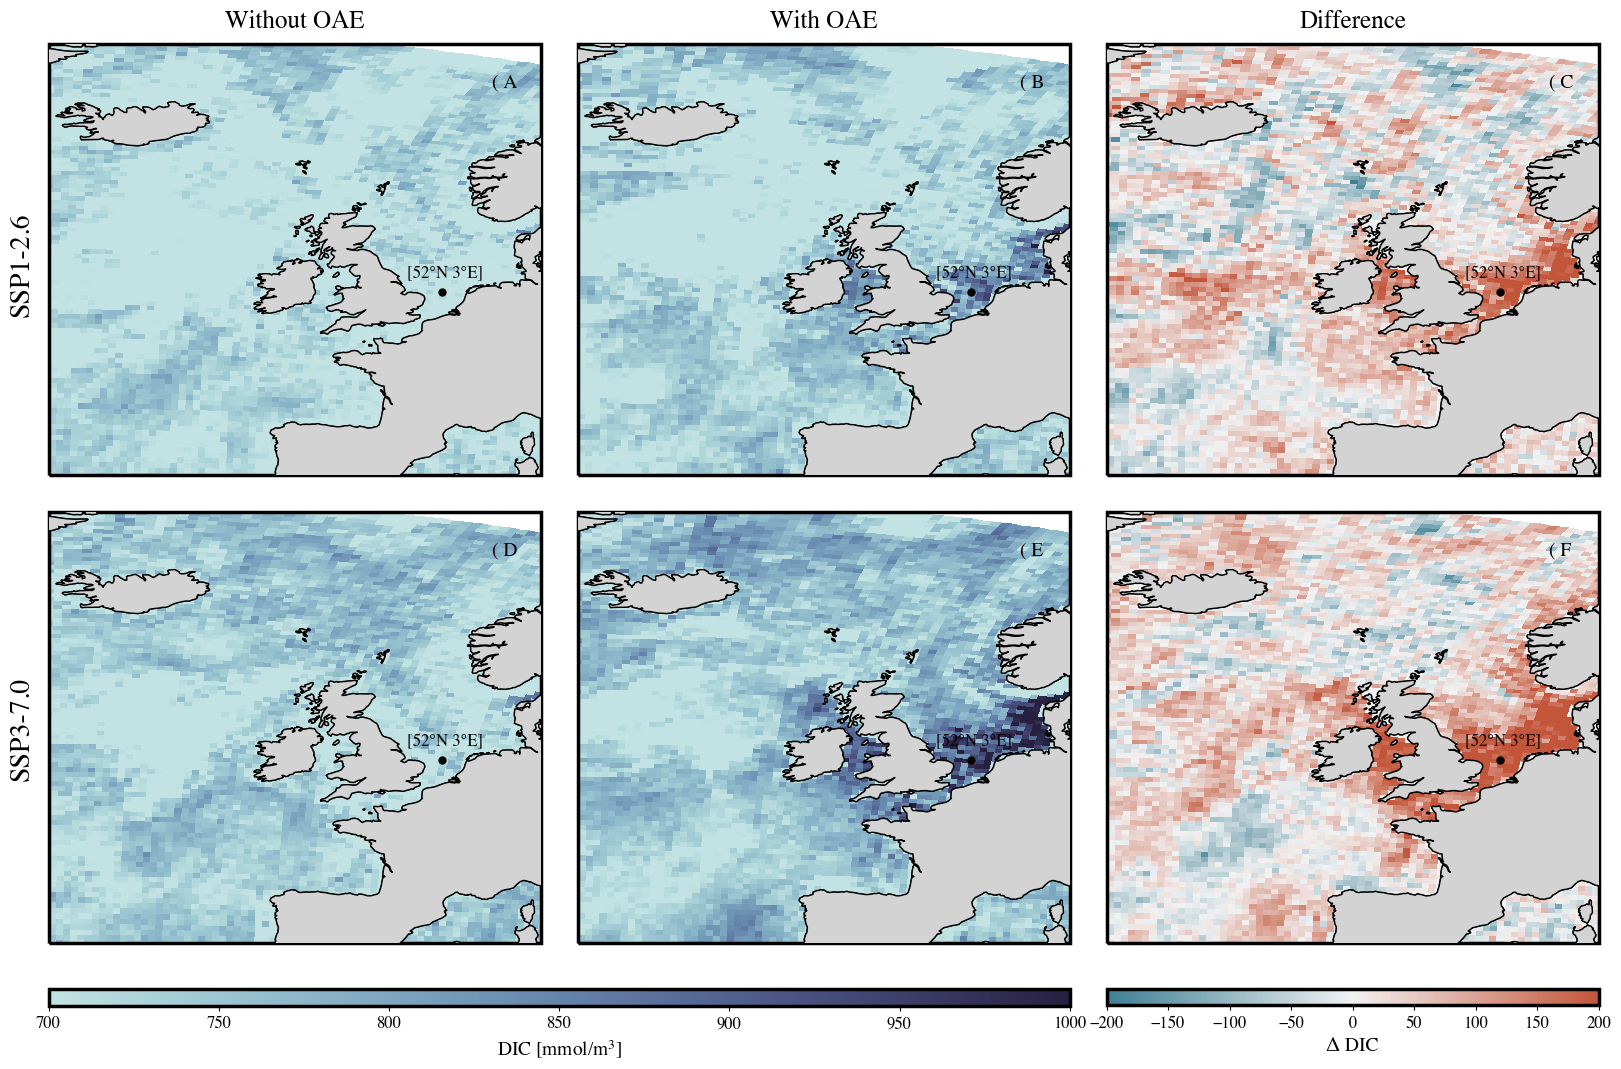

In [43]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 15))
plt.subplots_adjust(wspace=0.075, hspace=0)

im1 = amplitude_base_26_map.DIC.plot.pcolormesh(
        ax=ax1, x="nav_lon", y="nav_lat",
        vmin=700,
        vmax=1000,
        cmap=cmap,
        add_colorbar=False
    )
    
im2 = amplitude_oae_26_map.DIC.plot.pcolormesh(
        ax=ax2, x="nav_lon", y="nav_lat",
        vmin=700,
        vmax=1000,
        cmap=cmap,
        add_colorbar=False
    )
    
im3 = amplitude_change_26_map.DIC.plot.pcolormesh( 
        ax=ax3, x="nav_lon", y="nav_lat",
        vmin=-200,
        vmax=200,
        cmap=cmapdiff, 
        add_colorbar=False
    )
    
im4 = amplitude_base_70_map.DIC.plot.pcolormesh(
        ax=ax4, x="nav_lon", y="nav_lat",
        vmin=700,
        vmax=1000,
        cmap=cmap,
        add_colorbar=False
    )
    
im5 = amplitude_oae_70_map.DIC.plot.pcolormesh(
        ax=ax5, x="nav_lon", y="nav_lat",
        vmin=700,
        vmax=1000,
        cmap=cmap,
        add_colorbar=False
    )
    
im6 = amplitude_change_70_map.DIC.plot.pcolormesh( 
        ax=ax6, x="nav_lon", y="nav_lat",
        vmin=-200,
        vmax=200,
        cmap=cmapdiff, 
        add_colorbar=False
    )

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for ax in axes:
    ax.coastlines()
    ax.set_extent([-25, 10, 40, 70])
    ax.add_feature(cfeature.LAND, zorder=100, facecolor='lightgrey', edgecolor='black')
    ax.plot(3, 53, "o", color='black', markersize=5)
    ax.text(0.5, 54,'[52°N 3°E]', fontsize=12, color='black')

for ax in axes: 
    if ax == ax1:
        ax.set_title("Without OAE", fontsize=18, y=1.02)
    elif ax == ax2:
        ax.set_title("With OAE", fontsize=18, y=1.02),
    elif ax == ax3:
        ax.set_title("Difference", fontsize=18, y=1.02),
    else:
        ax.set_title("", fontsize=16, y=1.02)
        
for n, ax in enumerate(axes):
    ax.text(0.9, 0.9, string.punctuation[7] + ' ' + string.ascii_uppercase[n], transform=ax.transAxes, 
            size=14, weight='bold', color='black')

font_size = 12
        
cbar = plt.colorbar(im1, ax = [ax1, ax2, ax4, ax5], aspect = 60, pad=0.04, location='bottom')
cbar.set_label('DIC [mmol/$\mathregular{m^3}$]', fontsize=14)
cbar.ax.tick_params(labelsize=font_size)

cb3= plt.colorbar(im3,ax= [ax3, ax6], aspect = 30, pad=0.04, location='bottom')
cb3.set_label('Δ DIC', fontsize=14)
cb3.ax.yaxis.get_offset_text().set(size=14)
cb3.ax.tick_params(labelsize=font_size)
ax.text(-103,85, 'SSP1-2.6', rotation=90, fontsize=20)
ax.text(-103,52, 'SSP3-7.0', rotation=90, fontsize=20)

pass

plt.savefig('/Users/chiaraciscato/Desktop/geomar/geomarcode/finals/final_figs_mld/dic_amplitude.png')